In [1]:
# Python packages
from itertools import chain

import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

import pandas as pd

In [12]:
sys.path.insert(1, "/home/ubuntu/pidgin-rl/model")
# sys.path.insert(1, '../model')

from datasets import *
from decoder import *
from encoder_v2 import *
from train_encoder_v2 import *

In [40]:
plt.rcParams["figure.figsize"] = (7,7)


# Load Data

In [3]:
LANG = "en"
# LANG = "fr"

In [3]:
BATCH_SIZE = 32

In [4]:
# DATASET_PATH = '../generate-data/data_final/train/{}.csv'.format(LANG)
INDEXED_DATA_PATH = '../tokenizer/data_final/indexed_data_words.json' # dataset indexed
# TOKENIZED_DATA_PATH = "../tokenizer/data_final/tokens_words.json"
VOCAB_PATH = "../tokenizer/data_final/vocab_words.json"

In [6]:
dataset = pd.read_csv(DATASET_PATH).drop(columns=["Unnamed: 0"])
dataset.head()

,string,x,y
0,"move forty-eight to the left, then go down ten",-48,-10
1,go up eleven,0,11
2,move seventy-eight to the right and then go up...,78,20
3,move thirty-seven to the right then go down s...,37,-66
4,move seventy to the right and then go up sixt...,70,65


In [20]:
with open(VOCAB_PATH) as f:
  words = json.load(f)
words = pd.DataFrame.from_dict(words, orient='index', columns=["idx"]).reset_index()
words.drop(columns=["idx"], inplace=True)
words.rename(columns={"index":"label"}, inplace=True)
words.head()

,label
0,<pad>
1,<cls>
2,<eos>
3,allez
4,de


In [6]:
IX_TO_WORD = create_ix_to_vocab_map(VOCAB_PATH)

In [7]:
VOCAB_SIZE = len(words)

In [8]:
en_idx = [0, 1, 2, 6, 18, 19] + list(range(37, VOCAB_SIZE))
fr_idx = list(range(37))

In [9]:
{"<pad>": 0, "<cls>": 1, "<eos>": 2, "allez": 3, "de": 4, "cinquante": 5, "-": 6, "huit": 7, "\u00e0": 8, "droite": 9, "soixante": 10, "et": 11, "onze": 12, "gauche": 13, "puis": 14, "descendez": 15, "quatre": 16, "vingt": 17, "six": 18, ",": 19, "montez": 20, "quinze": 21, "trente": 22, "un": 23, "douze": 24, "neuf": 25, "quarante": 26, "dix": 27, "deux": 28, "sept": 29, "quatorze": 30, "vingts": 31, "cinq": 32, "trois": 33, "treize": 34, "seize": 35, "cent": 36, "move": 37, "forty": 38, "eight": 39, "to": 40, "the": 41, "left": 42, "then": 43, "go": 44, "down": 45, "ten": 46, "up": 47, "eleven": 48, "seventy": 49, "right": 50, "and": 51, "twenty": 52, "thirty": 53, "seven": 54, "sixty": 55, "five": 56, "nineteen": 57, "one": 58, "twelve": 59, "fifty": 60, "nine": 61, "eighty": 62, "three": 63, "ninety": 64, "two": 65, "seventeen": 66, "sixteen": 67, "four": 68, "fourteen": 69, "eighteen": 70, "fifteen": 71, "hundred": 72, "thirteen": 73}

{'<pad>': 0,
 '<cls>': 1,
 '<eos>': 2,
 'allez': 3,
 'de': 4,
 'cinquante': 5,
 '-': 6,
 'huit': 7,
 'à': 8,
 'droite': 9,
 'soixante': 10,
 'et': 11,
 'onze': 12,
 'gauche': 13,
 'puis': 14,
 'descendez': 15,
 'quatre': 16,
 'vingt': 17,
 'six': 18,
 ',': 19,
 'montez': 20,
 'quinze': 21,
 'trente': 22,
 'un': 23,
 'douze': 24,
 'neuf': 25,
 'quarante': 26,
 'dix': 27,
 'deux': 28,
 'sept': 29,
 'quatorze': 30,
 'vingts': 31,
 'cinq': 32,
 'trois': 33,
 'treize': 34,
 'seize': 35,
 'cent': 36,
 'move': 37,
 'forty': 38,
 'eight': 39,
 'to': 40,
 'the': 41,
 'left': 42,
 'then': 43,
 'go': 44,
 'down': 45,
 'ten': 46,
 'up': 47,
 'eleven': 48,
 'seventy': 49,
 'right': 50,
 'and': 51,
 'twenty': 52,
 'thirty': 53,
 'seven': 54,
 'sixty': 55,
 'five': 56,
 'nineteen': 57,
 'one': 58,
 'twelve': 59,
 'fifty': 60,
 'nine': 61,
 'eighty': 62,
 'three': 63,
 'ninety': 64,
 'two': 65,
 'seventeen': 66,
 'sixteen': 67,
 'four': 68,
 'fourteen': 69,
 'eighteen': 70,
 'fifteen': 71,
 'hundred':

# Load Model

Specifies the device, language, model type, and number of epochs, then loads in each checkpoint.

In [10]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

In [13]:
# Decoder or encoder
model_type = "encoder"
# model_type = "encoder"
N = 9 # last epoch we want

In [59]:
# N is the last epoch we want
# MODEL_CHECKPOINTS = ["../model/saved_models/{}_{}/model_epoch_{}.pt".format(
#     LANG, model_type, i) for i in range(1, N)]
epochs = [1, 4, 7]
prefix = "../model/saved_models/end2end/model_"
suffix = ".pt"
LOAD_PATHS = [
]

for epoch in epochs:
    for lang in ("en", "fr"):
        LOAD_PATHS.append(prefix + "from_" + lang + "_epoch_{}".format((epoch+1)//2) + suffix)
MODELS = [torch.load(checkpoint, map_location=device) for checkpoint in LOAD_PATHS]
EMBEDS = [list(model.children())[:-1][0] for model in MODELS]

In [60]:
print(EMBEDS)

[Linear(in_features=74, out_features=20, bias=True), Linear(in_features=74, out_features=20, bias=True), Linear(in_features=74, out_features=20, bias=True), Linear(in_features=74, out_features=20, bias=True), Linear(in_features=74, out_features=20, bias=True), Linear(in_features=74, out_features=20, bias=True)]


In [62]:
to_embed = torch.eye(VOCAB_SIZE, dtype=torch.float, device=device)
# to_embed = torch.tensor(range(VOCAB_SIZE), dtype=torch.long, device=device)

def make_word_embeddings(embed, words):
    """
    embed: embedding module
    """
    embeddings = embed(to_embed).cpu().detach().numpy()
    return pd.concat([words, pd.DataFrame(embeddings)], axis=1)

embeddings_for_models = [make_word_embeddings(embed, words) for embed in EMBEDS]

# Dimension reduction and Plotting

In [27]:
def PCA_(n, df):
    """
    PCAs df into n-dimensional df. Centers data automatically
    """
    pca = PCA(n_components=n)
    pca_df = pd.DataFrame(pca.fit_transform(np.array(df)))
    print('PCAed into shape: ', pca_df.shape)
    return pca_df

In [28]:
def tSNE(df):
    """
    t-SNEs df into 2 dimensions for visualization
    """
    X_embed = TSNE(n_components=2).fit_transform(df)
    print('t-SNEd into shape:', X_embed.shape)

    return X_embed

In [50]:
def plot_embeds(embeds, names, title='tSNE Visualization of Embeddings', save=True):
    """
    Plots embeddings with their corresponding names.

    embeds: N x 2 df where N[i] is a point to plot and names[i] is the corresponding label

    """
    embeds = np.array(embeds)
    for i, embed in enumerate(embeds):
        plt.scatter(embed[0], embed[1])
        plt.text(embed[0] + 0.05, embed[1] - 0.07, names[i], fontsize=9)

    plt.title(title)
    if save: plt.savefig(title + ".png")
    plt.show()

In [63]:
# SPLIT DATASET INTO ENGLISH/FRENCH
to_pca_models = [embedding[embedding.columns.tolist()[1:]] for embedding in embeddings_for_models]

def split_languages(to_pca):
    to_pca_en = to_pca.iloc[en_idx, :]
    to_pca_fr = to_pca.iloc[fr_idx, :]

    display(to_pca.head())
    return to_pca_en, to_pca_fr

In [64]:
to_pca_both = [split_languages(to_pca) for to_pca in to_pca_models]
to_pca_en_models = [to_pca[0] for to_pca in to_pca_both]
to_pca_fr_models = [to_pca[1] for to_pca in to_pca_both]
# Now we have a list of word embedding matrices for english words and for french words, where list[i] is the
# emb matrix for the ith model

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.368893,-0.060418,0.423279,0.622090,-0.149061,0.099981,-0.078142,-0.287731,-0.213302,-0.450031,-0.229026,-0.312978,-0.071788,-0.148405,0.180074,0.254665,-0.366410,-0.433957,0.095471,-0.048674
1,0.596746,-0.334631,0.535565,0.849508,-0.295274,0.113059,0.241644,-0.217721,-0.409472,-0.619801,-0.529157,0.840534,-0.250140,0.037610,0.187691,0.054390,-0.688592,-0.140308,0.073163,-0.090085
2,0.225785,-0.350146,1.371339,0.954306,-0.578555,0.659699,-0.829691,-0.824813,1.424430,-0.218723,1.424731,0.078852,-1.660389,-0.293441,1.247643,-0.060498,-0.195776,-0.824673,1.209361,0.279618
3,0.737615,0.089443,0.566867,0.779252,-0.408493,-0.000699,-0.092352,-0.688289,-0.168415,-0.952988,-0.063876,-0.344823,0.344121,-0.504777,0.331009,0.315004,-0.736857,-1.157016,0.264909,-0.352255
4,0.235362,-0.064302,1.237474,1.185412,-0.335722,-0.052251,-0.094699,-0.291893,-0.367834,-0.446850,-0.454035,-0.164841,-0.595791,-0.292501,0.060214,0.858491,-0.479052,-0.723832,0.436167,0.097603


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.368893,-0.060418,0.423279,0.622090,-0.149061,0.099981,-0.078142,-0.287731,-0.213302,-0.450031,-0.229026,-0.312978,-0.071788,-0.148405,0.180074,0.254665,-0.366410,-0.433957,0.095471,-0.048674
1,0.596746,-0.334631,0.535565,0.849508,-0.295274,0.113059,0.241644,-0.217721,-0.409472,-0.619801,-0.529157,0.840534,-0.250140,0.037610,0.187691,0.054390,-0.688592,-0.140308,0.073163,-0.090085
2,0.225785,-0.350146,1.371339,0.954306,-0.578555,0.659699,-0.829691,-0.824813,1.424430,-0.218723,1.424731,0.078852,-1.660389,-0.293441,1.247643,-0.060498,-0.195776,-0.824673,1.209361,0.279618
3,0.737615,0.089443,0.566867,0.779252,-0.408493,-0.000699,-0.092352,-0.688289,-0.168415,-0.952988,-0.063876,-0.344823,0.344121,-0.504777,0.331009,0.315004,-0.736857,-1.157016,0.264909,-0.352255
4,0.235362,-0.064302,1.237474,1.185412,-0.335722,-0.052251,-0.094699,-0.291893,-0.367834,-0.446850,-0.454035,-0.164841,-0.595791,-0.292501,0.060214,0.858491,-0.479052,-0.723832,0.436167,0.097603


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.409429,-0.055768,0.423652,0.605205,-0.141983,0.101596,-0.105255,-0.320755,-0.163336,-0.465394,-0.175946,-0.376022,-0.079183,-0.167658,0.132961,0.298495,-0.352771,-0.450967,0.063161,-0.060692
1,0.675890,-0.359417,0.547369,0.840306,-0.278911,0.104671,0.215966,-0.263926,-0.357893,-0.610153,-0.417888,0.709958,-0.259659,0.017113,0.106847,0.100839,-0.619948,-0.200970,0.037952,-0.079266
2,0.266321,-0.345496,1.371711,0.937421,-0.571478,0.661314,-0.856804,-0.857838,1.474397,-0.234086,1.477811,0.015808,-1.667783,-0.312694,1.200530,-0.016667,-0.182137,-0.841683,1.177052,0.267600
3,0.796176,0.159794,0.600732,0.734192,-0.382891,0.048989,-0.127317,-0.730085,-0.095383,-1.022776,-0.060465,-0.433430,0.358149,-0.528111,0.294384,0.453608,-0.704407,-1.151751,0.174963,-0.429262
4,0.277150,-0.061024,1.236762,1.169056,-0.327760,-0.052533,-0.119244,-0.323801,-0.317294,-0.461744,-0.403273,-0.229586,-0.601395,-0.311369,0.015984,0.901444,-0.462234,-0.742120,0.405809,0.085028


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.409429,-0.055768,0.423652,0.605205,-0.141983,0.101596,-0.105255,-0.320755,-0.163336,-0.465394,-0.175946,-0.376022,-0.079183,-0.167658,0.132961,0.298495,-0.352771,-0.450967,0.063161,-0.060692
1,0.675890,-0.359417,0.547369,0.840306,-0.278911,0.104671,0.215966,-0.263926,-0.357893,-0.610153,-0.417888,0.709958,-0.259659,0.017113,0.106847,0.100839,-0.619948,-0.200970,0.037952,-0.079266
2,0.266321,-0.345496,1.371711,0.937421,-0.571478,0.661314,-0.856804,-0.857838,1.474397,-0.234086,1.477811,0.015808,-1.667783,-0.312694,1.200530,-0.016667,-0.182137,-0.841683,1.177052,0.267600
3,0.796176,0.159794,0.600732,0.734192,-0.382891,0.048989,-0.127317,-0.730085,-0.095383,-1.022776,-0.060465,-0.433430,0.358149,-0.528111,0.294384,0.453608,-0.704407,-1.151751,0.174963,-0.429262
4,0.277150,-0.061024,1.236762,1.169056,-0.327760,-0.052533,-0.119244,-0.323801,-0.317294,-0.461744,-0.403273,-0.229586,-0.601395,-0.311369,0.015984,0.901444,-0.462234,-0.742120,0.405809,0.085028


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.461278,-0.081025,0.402644,0.571446,-0.116476,0.125512,-0.139425,-0.359699,-0.101259,-0.450802,-0.154896,-0.411173,-0.104294,-0.244388,0.112659,0.313148,-0.304110,-0.498879,0.085441,-0.076944
1,0.811028,-0.457392,0.473971,0.784169,-0.251074,0.154539,0.131420,-0.344891,-0.203148,-0.580122,-0.346948,0.600223,-0.313963,-0.133406,0.056275,0.129178,-0.492123,-0.298801,0.060575,-0.098596
2,0.318169,-0.370753,1.350703,0.903662,-0.545971,0.685229,-0.890975,-0.896781,1.536473,-0.219494,1.498861,-0.019343,-1.692895,-0.389424,1.180228,-0.002015,-0.133475,-0.889596,1.199331,0.251348
3,0.856467,0.213079,0.609003,0.671711,-0.346922,0.090708,-0.193622,-0.779841,-0.021356,-0.999942,-0.045115,-0.455834,0.323185,-0.651346,0.257808,0.525892,-0.650880,-1.231455,0.217837,-0.495786
4,0.328297,-0.086503,1.215666,1.134867,-0.302836,-0.028289,-0.153780,-0.362546,-0.255874,-0.446452,-0.381763,-0.264496,-0.626077,-0.388139,-0.003784,0.916197,-0.414062,-0.789592,0.428148,0.069008


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.461278,-0.081025,0.402644,0.571446,-0.116476,0.125512,-0.139425,-0.359699,-0.101259,-0.450802,-0.154896,-0.411173,-0.104294,-0.244388,0.112659,0.313148,-0.304110,-0.498879,0.085441,-0.076944
1,0.811028,-0.457392,0.473971,0.784169,-0.251074,0.154539,0.131420,-0.344891,-0.203148,-0.580122,-0.346948,0.600223,-0.313963,-0.133406,0.056275,0.129178,-0.492123,-0.298801,0.060575,-0.098596
2,0.318169,-0.370753,1.350703,0.903662,-0.545971,0.685229,-0.890975,-0.896781,1.536473,-0.219494,1.498861,-0.019343,-1.692895,-0.389424,1.180228,-0.002015,-0.133475,-0.889596,1.199331,0.251348
3,0.856467,0.213079,0.609003,0.671711,-0.346922,0.090708,-0.193622,-0.779841,-0.021356,-0.999942,-0.045115,-0.455834,0.323185,-0.651346,0.257808,0.525892,-0.650880,-1.231455,0.217837,-0.495786
4,0.328297,-0.086503,1.215666,1.134867,-0.302836,-0.028289,-0.153780,-0.362546,-0.255874,-0.446452,-0.381763,-0.264496,-0.626077,-0.388139,-0.003784,0.916197,-0.414062,-0.789592,0.428148,0.069008


In [65]:
# PCA
pcaed_en = [PCA_(2, to_pca_en) for to_pca_en in to_pca_en_models]
pcaed_fr = [PCA_(2, to_pca_fr) for to_pca_fr in to_pca_fr_models]

PCAed into shape:  (43, 2)
PCAed into shape:  (43, 2)
PCAed into shape:  (43, 2)
PCAed into shape:  (43, 2)
PCAed into shape:  (43, 2)
PCAed into shape:  (43, 2)
PCAed into shape:  (37, 2)
PCAed into shape:  (37, 2)
PCAed into shape:  (37, 2)
PCAed into shape:  (37, 2)
PCAed into shape:  (37, 2)
PCAed into shape:  (37, 2)


In [66]:
def plot_pca_for_list(pcaed, idx, lang):
    # PLOT PCA
    for i, emb in enumerate(pcaed):    
        name = LOAD_PATHS[i].split('/')
        name = name[-1]
        name = name.split('.')[0].split('_')[1:]
        name[-2] = "ep."
        name = " ".join(name)
        title = "{} PCA Embeddings for {}".format(lang, name)
        plot_embeds(emb, list(words.iloc[idx,:]['label']), title=title, save=True)
        
def plot_tsne_for_list(tsned, idx, lang):
    # PLOT tsne
    for i, emb in enumerate(tsned):    
        name = LOAD_PATHS[i].split('/')
        name = name[-1]
        name = name.split('.')[0].split('_')[1:]
        name[-2] = "ep."
        name = " ".join(name)
        title = "tSNE {} Embeddings for {}".format(lang, name)
        plot_embeds(emb, list(words.iloc[idx,:]['label']), title=title, save=True)

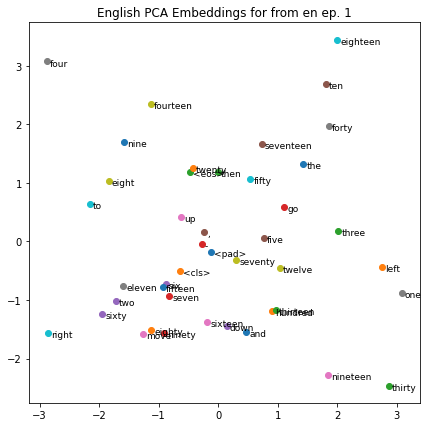

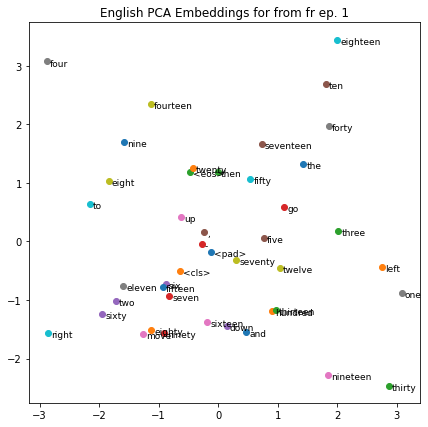

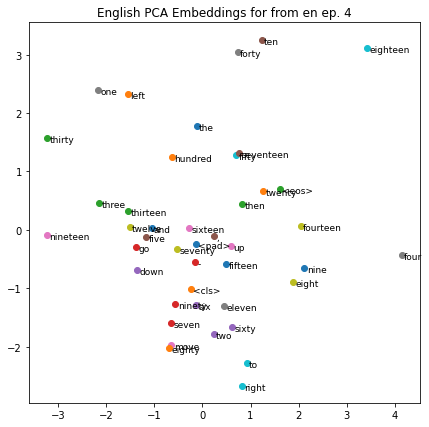

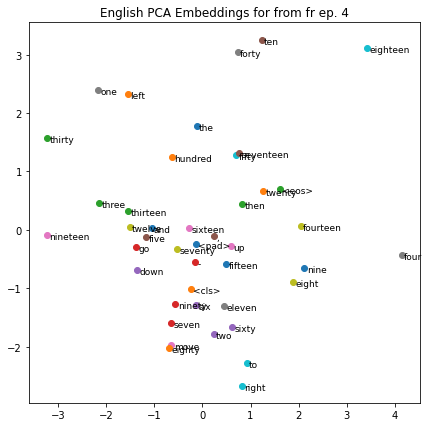

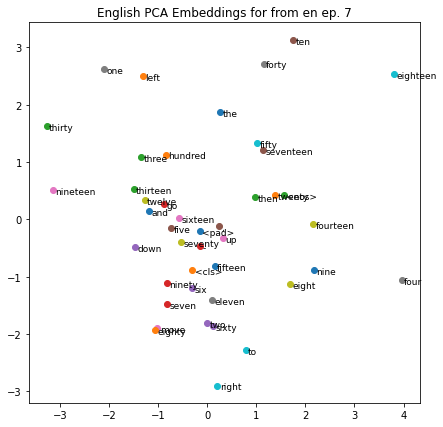

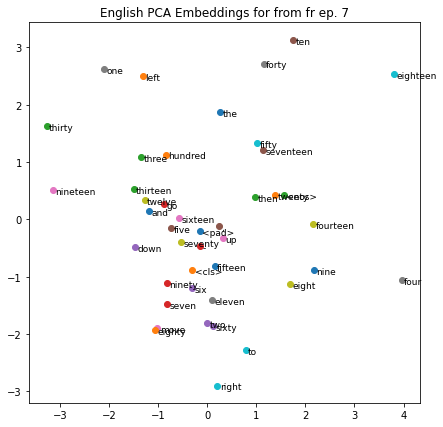

In [67]:
# PLOT PCA
plot_pca_for_list(pcaed_en, en_idx, "English")

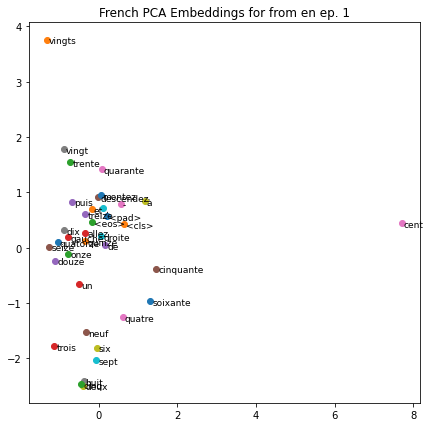

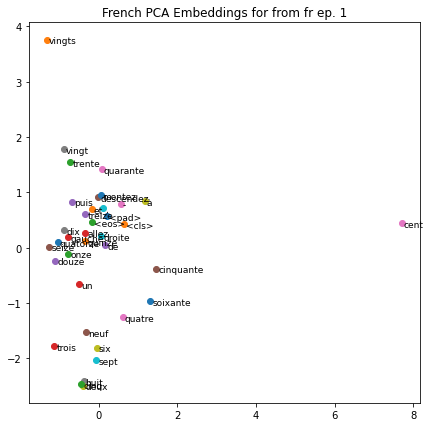

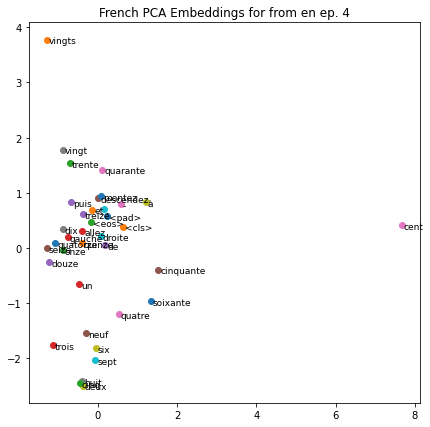

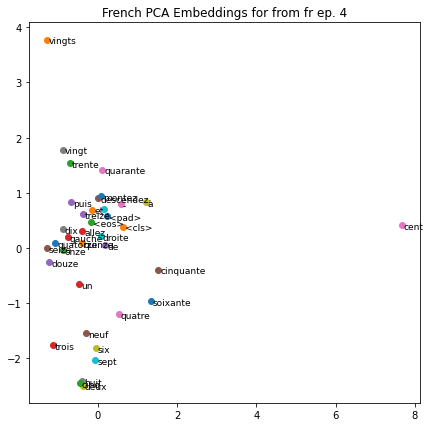

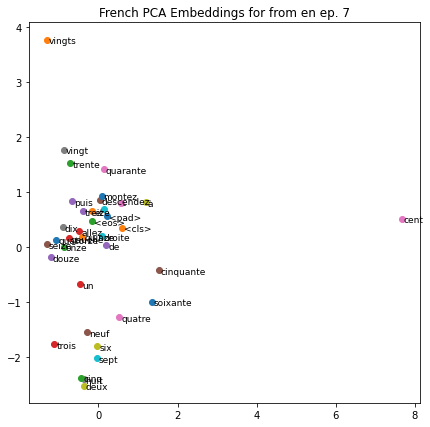

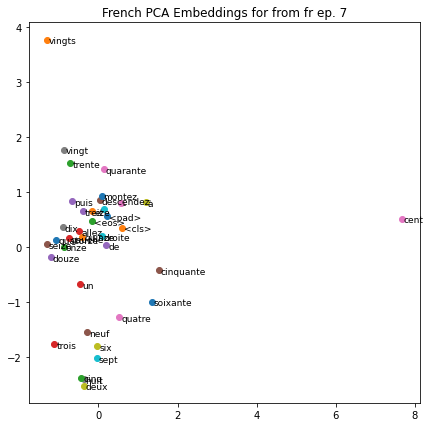

In [68]:
# PLOT PCA FR
plot_pca_for_list(pcaed_fr, fr_idx, "French")

In [43]:
# TSNE
tsed_en = [tSNE(to_pca_en) for to_pca_en in to_pca_en_models]
tsned_fr = [tSNE(to_pca_fr) for to_pca_fr in to_pca_fr_models]

t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (43, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)
t-SNEd into shape: (37, 2)


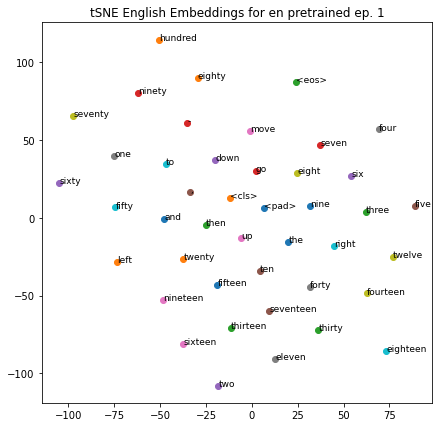

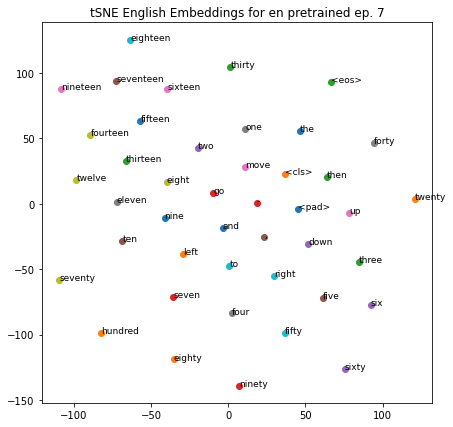

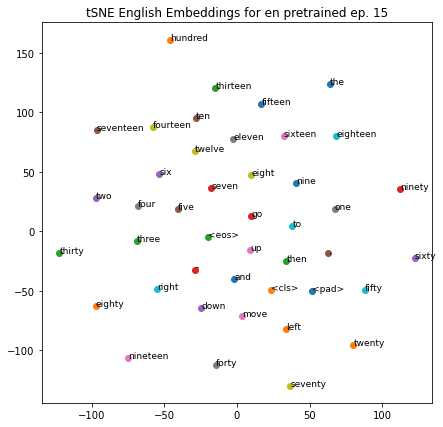

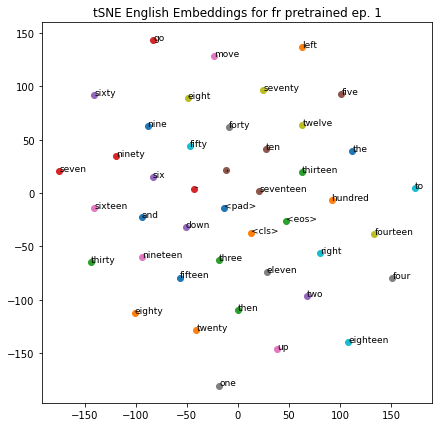

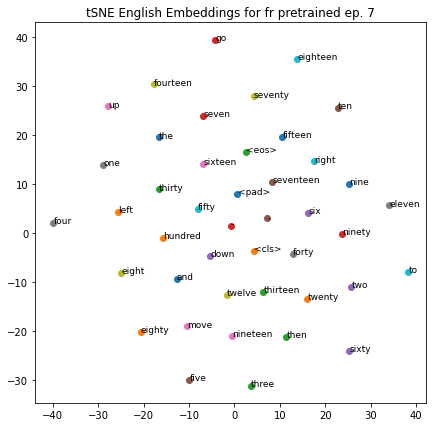

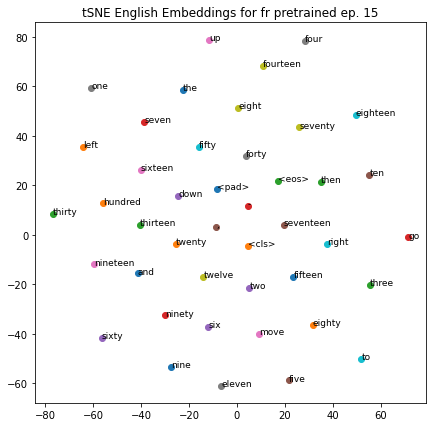

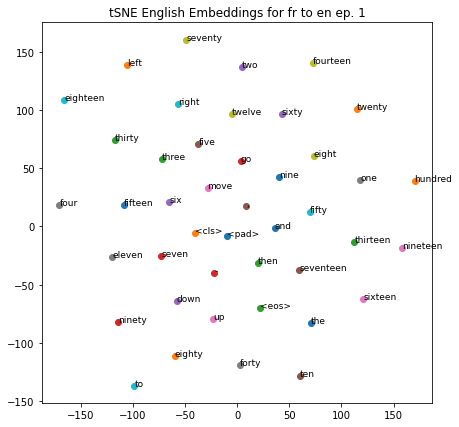

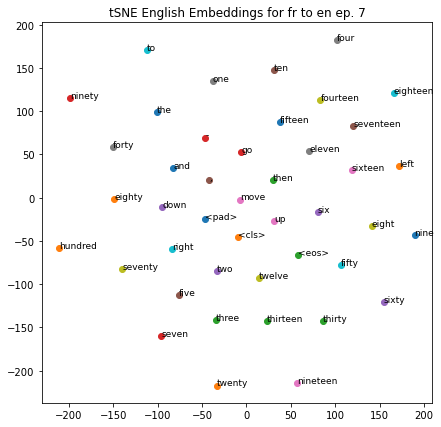

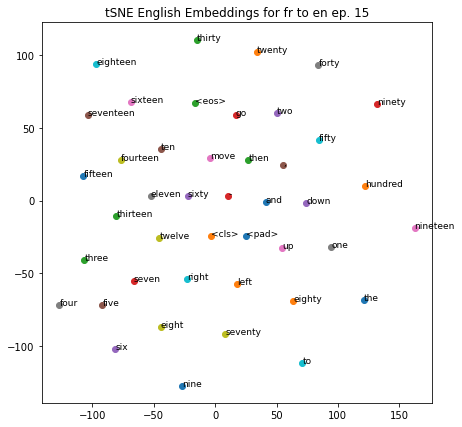

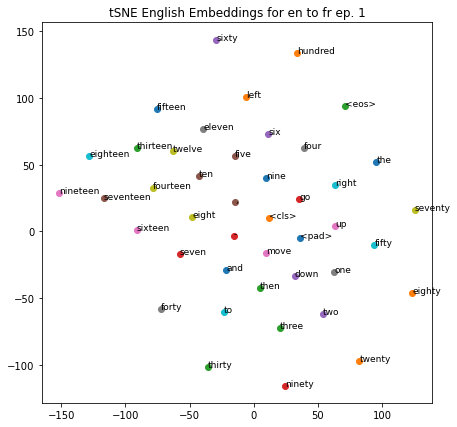

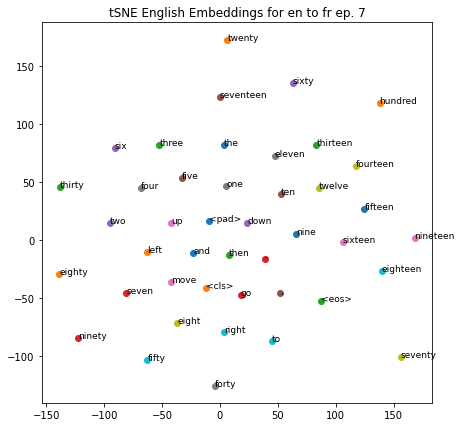

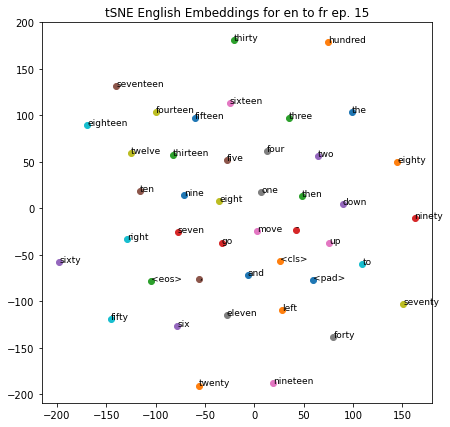

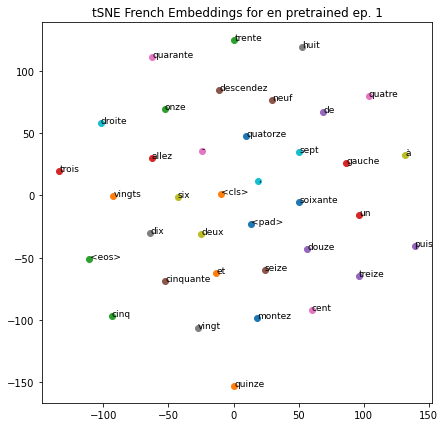

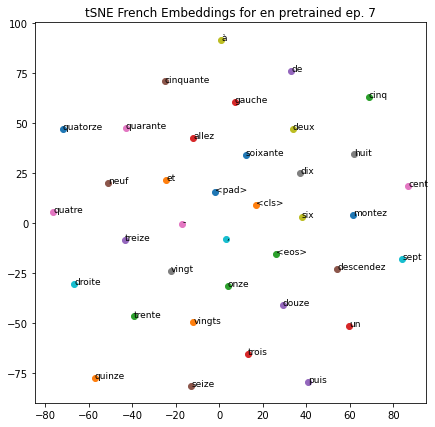

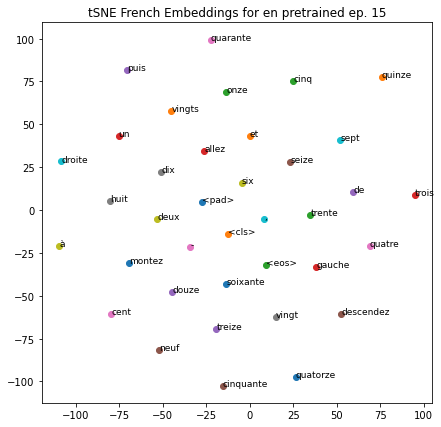

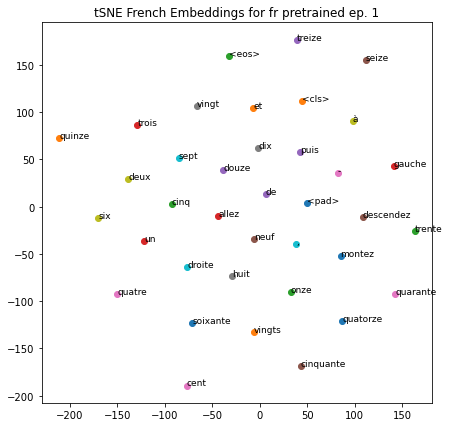

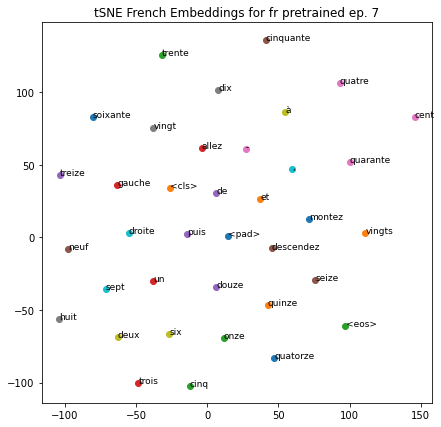

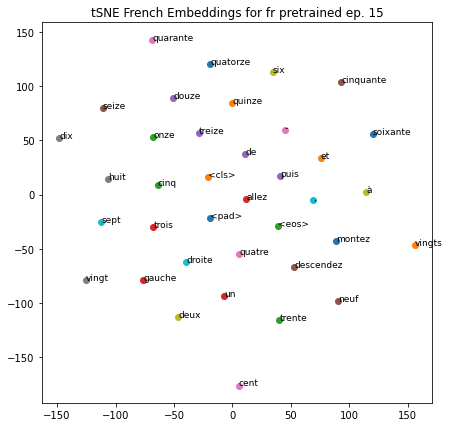

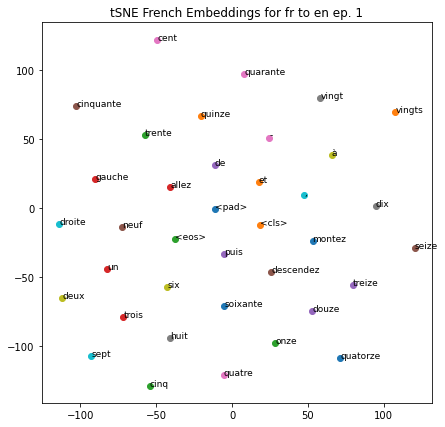

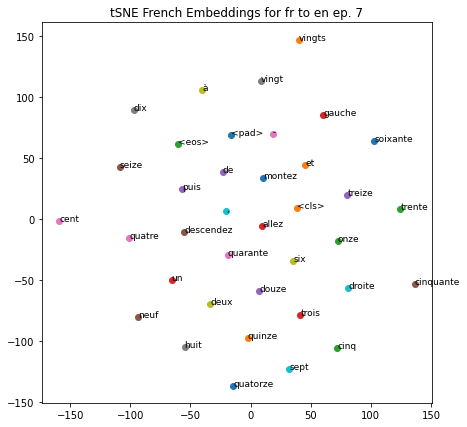

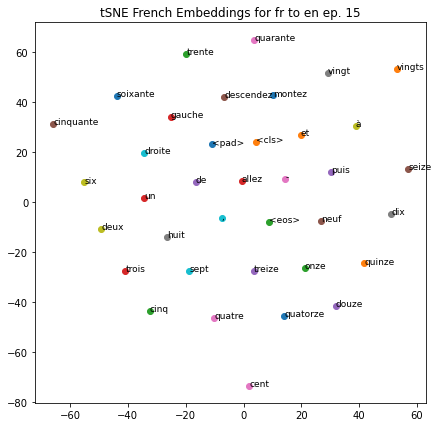

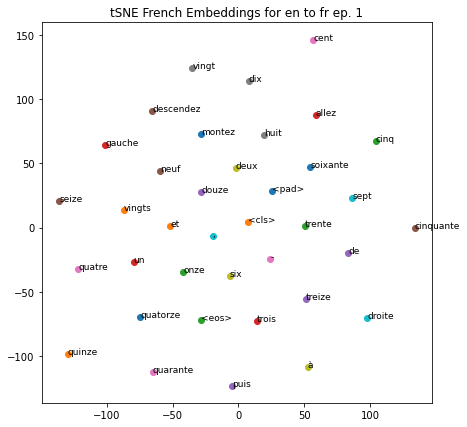

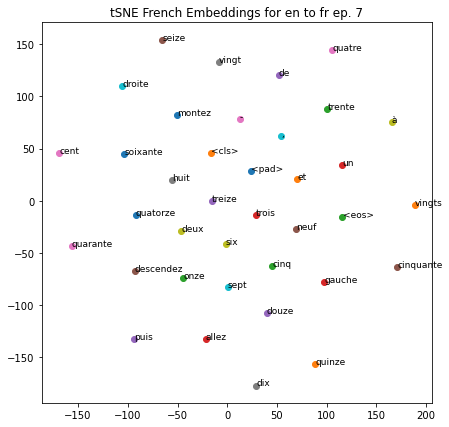

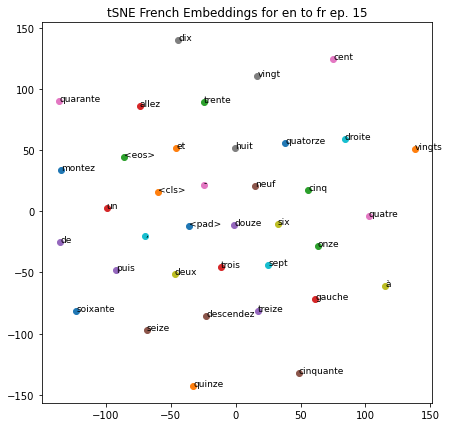

In [57]:
# tSNE ENGLISH
plot_tsne_for_list(tsed_en, en_idx, "English")
plot_tsne_for_list(tsned_fr, fr_idx, "French")

# Distance matrix

In [24]:
def plot_matrix(mat, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(mat)
    plt.title(title)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes, {'fontsize': 7})
    ax.set_yticklabels(classes, {'fontsize': 7})

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.colorbar(im)
    plt.show()

def vis_distance_matrix(df, classes, title, cos=True):
    """
    Visualize pairwise cosine distances between rows of the df.
    df should be a pandas dataframe of embedding vectors.
    """
    embeds = np.array(df)

    if cos:
        embeds = normalize(embeds, norm='l2', axis=1, copy=True, return_norm=False)
    dists = distance_matrix(embeds, embeds, p=2)
    
    plot_matrix(dists, classes, title)

    return dists


# Sentence Generation (run only if encoder)

In [76]:
def get_perplexity(loss):
    """
    loss: per-word loss from evaluation
    A perplexity of random guessing is vocab size = 74. Anything lower is extremely good.
    """
    return math.exp(loss)

In [97]:
LANG

'en'

In [ ]:
# Load english data set
iters = load_data(DATASET_PATH, INDEXED_DATA_PATH, LANG, BATCH_SIZE, device)
_, _, en_test_iter = iters
print('Finished loading english data')

# Load french dataset
iters = load_data('../generate-data/data_final/train/fr.csv', INDEXED_DATA_PATH, 'fr', BATCH_SIZE, device)
X_str, train_iter, fr_test_iter = iters
print('Finished loading  data')



Loading data...


In [28]:
from train_jointly import evaluate as joint_eval

In [86]:
# Load in models over time
def get_checkpoints(model_dir = '../model/saved_models/en'):
    '''
    Load in all model checkpoints, save as dict
    '''
    checkpoints = {}
    for file in os.listdir(model_dir):
        epoch_num = int(file.split('_')[-1][0])
        model_path = os.path.join(model_dir, file)
        checkpoints[epoch_num] = torch.load(model_path)
    return checkpoints

In [87]:
# Get english and french checkpoints
en_checkpoints = get_checkpoints()
fr_checkpoints = get_checkpoints('../model/saved_models/fr')

/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'agent.Agent' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'decoder.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [92]:
# Get loss afer 
def eval_checkpoints(checkpoints, data, device):
    '''
    Evaluate model checkpoints using provide data
    '''
    LOSSES = []
    for c_ix in range(1, len(checkpoints)+1):
        model = checkpoints[c_ix]
        dec_criterion = nn.MSELoss()
        enc_criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
        loss = joint_eval(model, data, enc_criterion, dec_criterion, device, args=None, type='Test')
        LOSSES.append(loss)
        print(f"Loss for epoch {c_ix}: {loss}",flush=True,end='\r')
    return LOSSES

In [ ]:
en_losses_on_english = eval

/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


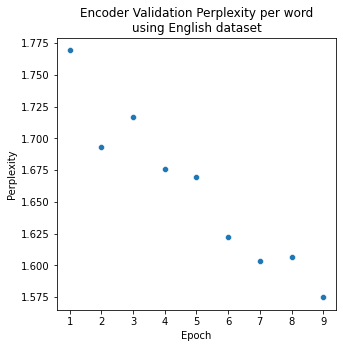

In [79]:
# Plot encoder loss
import seaborn as sns

enc_perp = [get_perplexity(l[0]/(32*24)) for l in LOSSES]

fig, axs = plt.subplots(1, figsize=(5,5))
sns.scatterplot(range(1,10), enc_perp, ax=axs)
axs.set_title('English MonolingualEncoder Validation Perplexity per word\nusing English dataset')
axs.set(xlabel='Epoch', ylabel='Perplexity');

/home/ubuntu/miniconda3/envs/9190/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


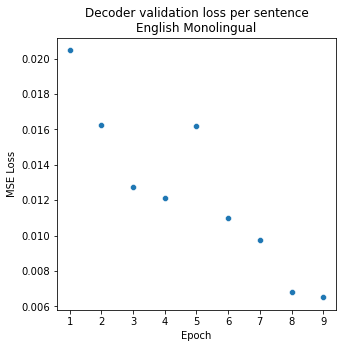

In [84]:
dec_loss = [l[1]*100**2/32 for l in LOSSES]
fig, axs = plt.subplots(1, figsize=(5,5))
sns.scatterplot(range(1,10), dec_loss, ax=axs)
axs.set_title('Decoder validation loss per sentence\nEnglish Monolingual')
axs.set(xlabel='Epoch', ylabel='MSE Loss');